In [1]:
# Core Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import squarify
%matplotlib inline

# Machine Learning Libraries
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, HistGradientBoostingClassifier

# Set random seed
rs = 42

# Ignore warnings
warnings.filterwarnings("ignore")

# Set color palette for Seaborn
colors= ['#c9e4d0', '#a2d1ae', '#7bbe8c', '#54AB6A', '#418653', '#2e5f3b', '#1b3823']
sns.set_palette(colors)

In [2]:
df_train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")

print("First 5 rows of our dataset:")
df_train.head()

First 5 rows of our dataset:


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [3]:
print(f"There are {df_train.shape[1]} columns and {df_train.shape[0]} rows in the train dataset.")

There are 20 columns and 140700 rows in the train dataset.


In [4]:
print("Column names and data type of each column:")
df_train.dtypes

Column names and data type of each column:


id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

In [5]:
# Save 'id' column for submission
test_ids = df_test['id']

# Drop 'id' column in both datasets
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

# Define the target column
target_column = 'Depression'

# Select categorical and numerical columns (initial)
categorical_columns = df_train.select_dtypes(include=['object']).columns
numerical_columns = df_train.select_dtypes(exclude=['object']).columns.drop(target_column)

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: Depression

Categorical Columns: ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

Numerical Columns: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']


In [6]:
for column in categorical_columns:
    num_unique = df_train[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'Name' has 422 unique categories.
'Gender' has 2 unique categories.
'City' has 98 unique categories.
'Working Professional or Student' has 2 unique categories.
'Profession' has 64 unique categories.
'Sleep Duration' has 36 unique categories.
'Dietary Habits' has 23 unique categories.
'Degree' has 115 unique categories.
'Have you ever had suicidal thoughts ?' has 2 unique categories.
'Family History of Mental Illness' has 2 unique categories.


In [7]:
# Print top 10 unique value counts for each categorical column
for column in categorical_columns:
    print(f"\nTop value counts in '{column}':\n{df_train[column].value_counts().head(10)}")


Top value counts in 'Name':
Name
Rohan          3178
Aarav          2336
Rupak          2176
Aaradhya       2045
Anvi           2035
Raghavendra    1877
Vani           1657
Tushar         1596
Ritvik         1589
Shiv           1568
Name: count, dtype: int64

Top value counts in 'Gender':
Gender
Male      77464
Female    63236
Name: count, dtype: int64

Top value counts in 'City':
City
Kalyan           6591
Patna            5924
Vasai-Virar      5765
Kolkata          5689
Ahmedabad        5613
Meerut           5528
Ludhiana         5226
Pune             5210
Rajkot           5207
Visakhapatnam    5176
Name: count, dtype: int64

Top value counts in 'Working Professional or Student':
Working Professional or Student
Working Professional    112799
Student                  27901
Name: count, dtype: int64

Top value counts in 'Profession':
Profession
Teacher             24906
Content Writer       7814
Architect            4370
Consultant           4229
HR Manager           4022
Pharmacist  

In [8]:
print("The skewness of columns:")
print(df_train[numerical_columns].skew())

The skewness of columns:
Age                  -0.217977
Academic Pressure    -0.133977
Work Pressure         0.018515
CGPA                 -0.073636
Study Satisfaction    0.011764
Job Satisfaction      0.054361
Work/Study Hours     -0.128169
Financial Stress      0.035603
dtype: float64


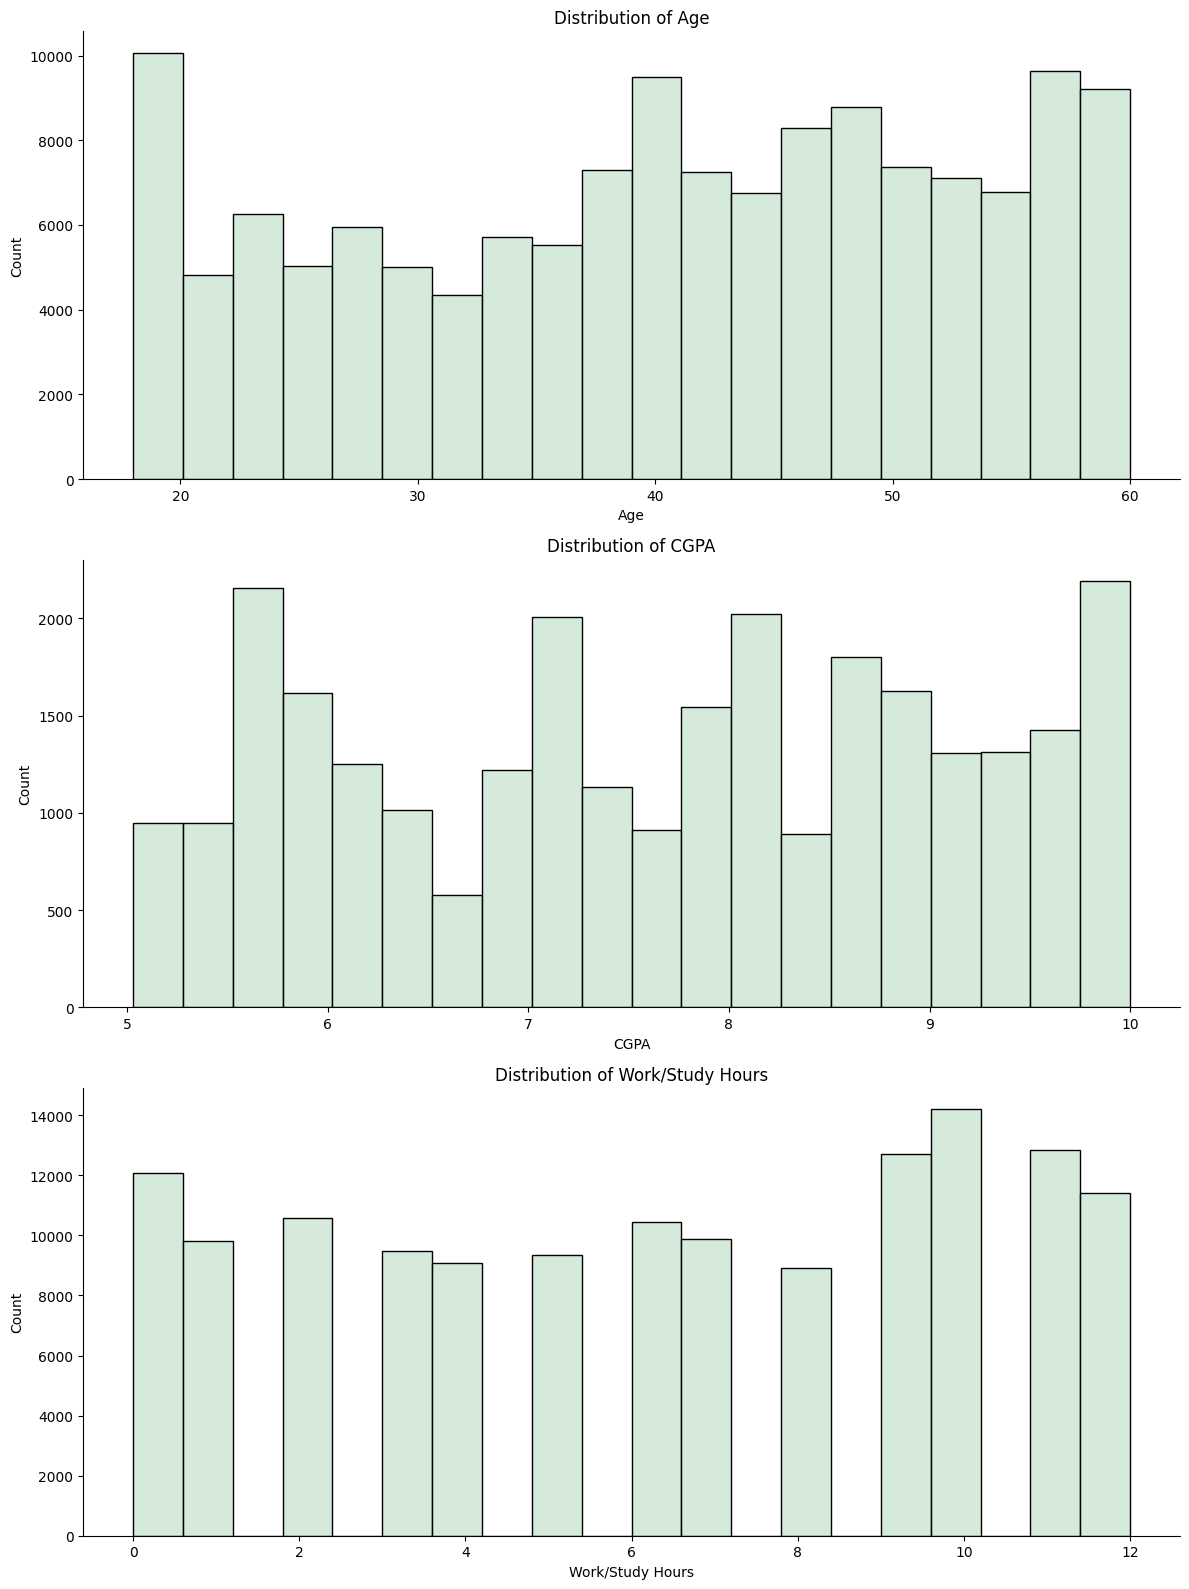

In [9]:
numerical_columns_to_plot = ["Age", "CGPA", "Work/Study Hours"]

plt.figure(figsize=(12, 16)) 

for i, column in enumerate(numerical_columns_to_plot):
    plt.subplot(3, 1, i+1)
    sns.histplot(data=df_train, x=column, kde=False, bins=20, color=colors[0])
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

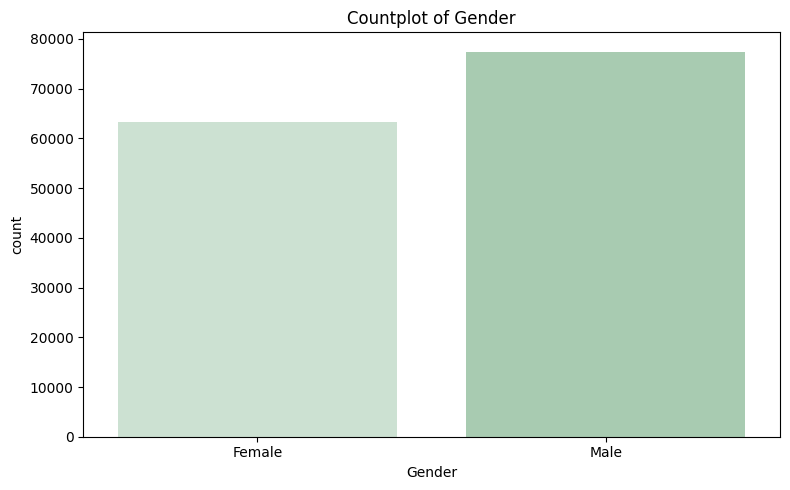

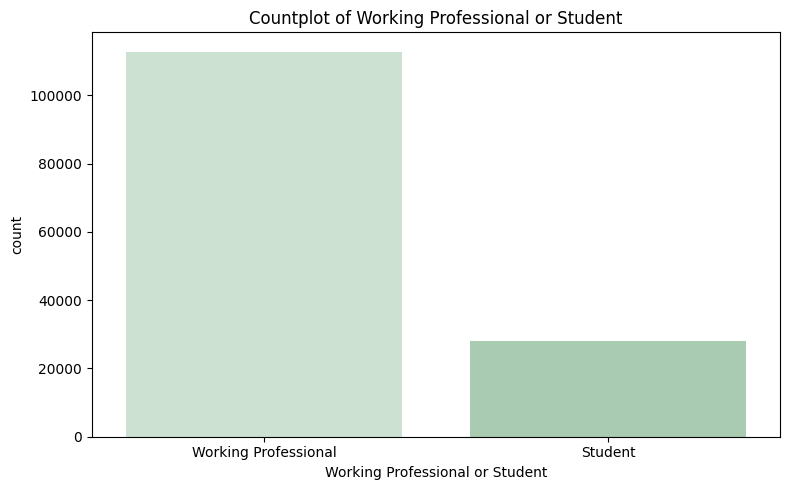

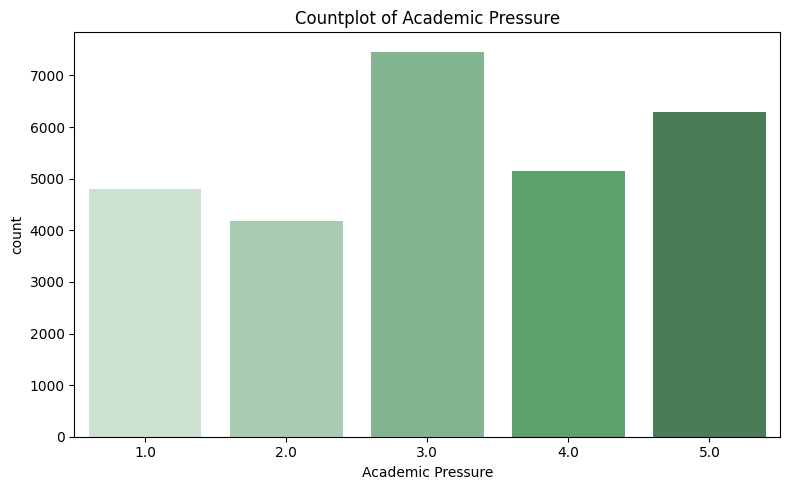

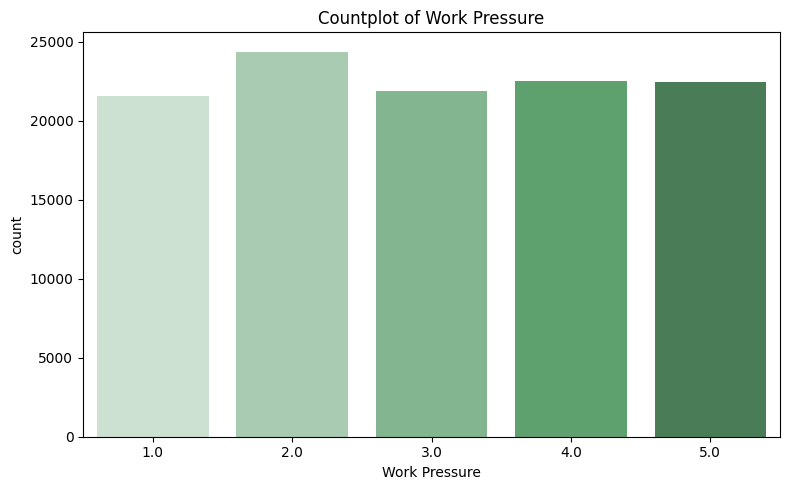

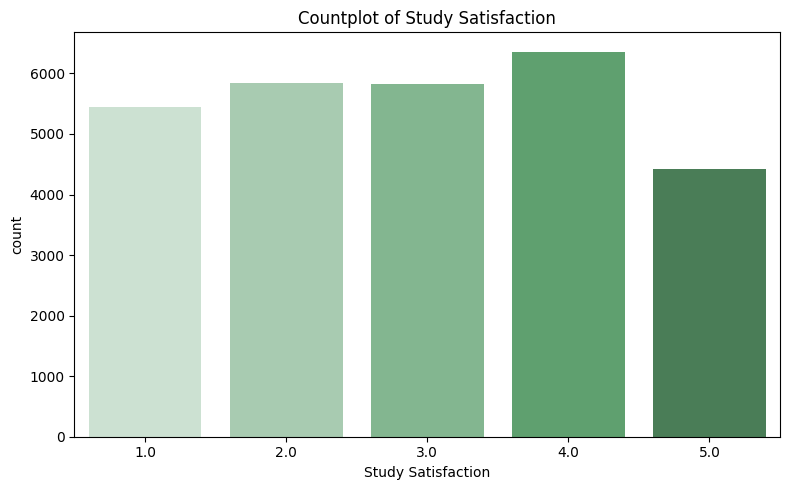

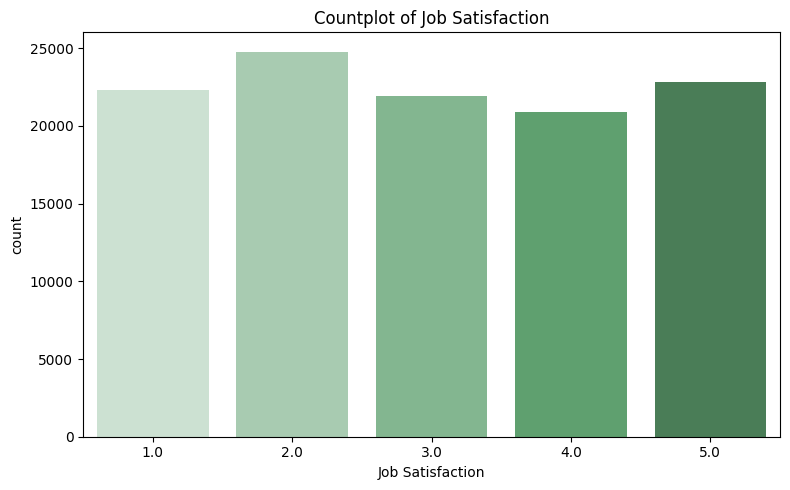

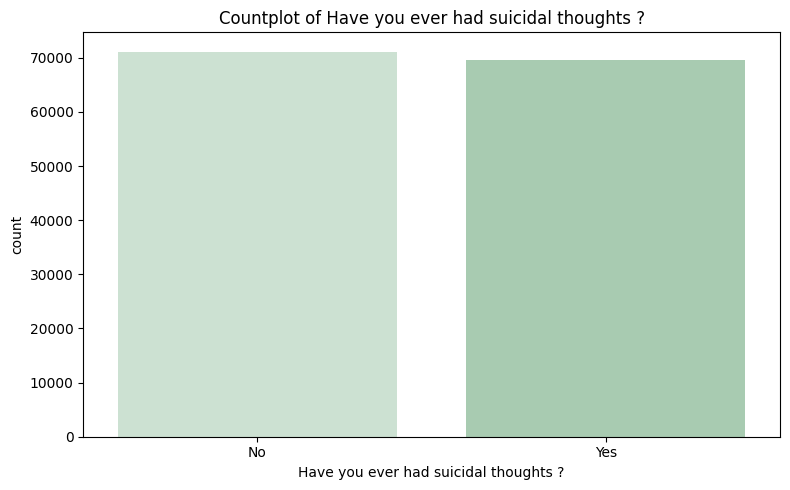

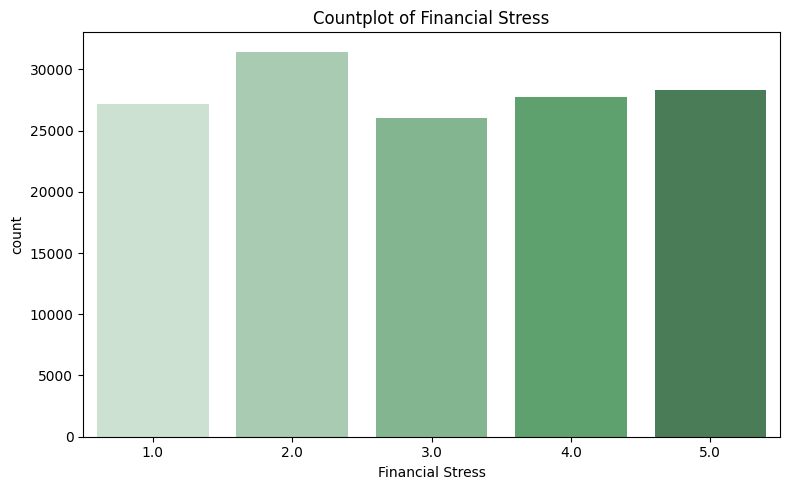

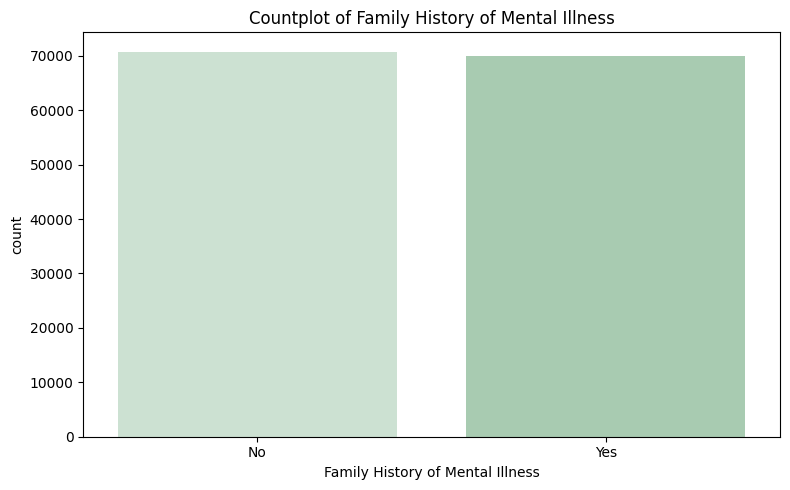

In [10]:
categorical_columns_to_plot = ['Gender', 'Working Professional or Student', 'Academic Pressure', 
                       'Work Pressure', 'Study Satisfaction', 'Job Satisfaction',
                       'Have you ever had suicidal thoughts ?', 'Financial Stress', 
                       'Family History of Mental Illness']

# Plot countplots for each categorical column
for column in categorical_columns_to_plot:
    
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_train, x=column)
    plt.title(f'Countplot of {column}')
    
    plt.tight_layout()
    plt.show()

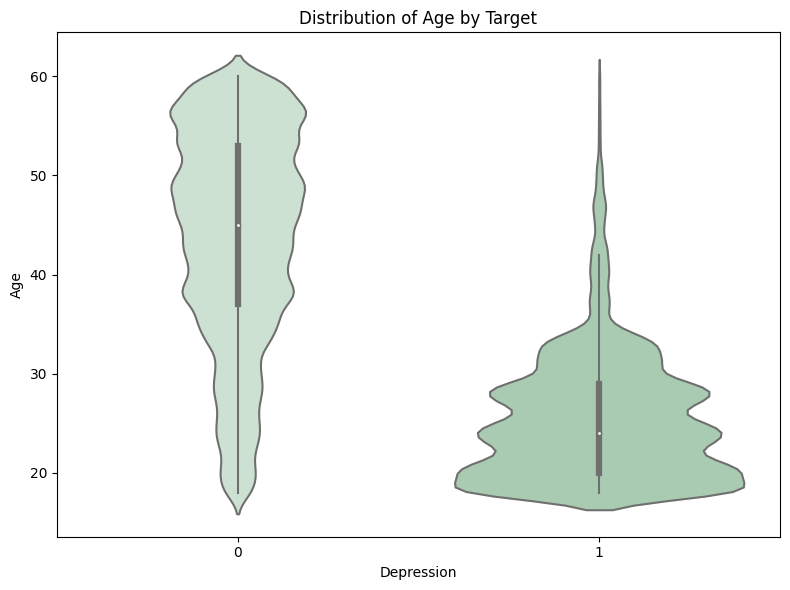

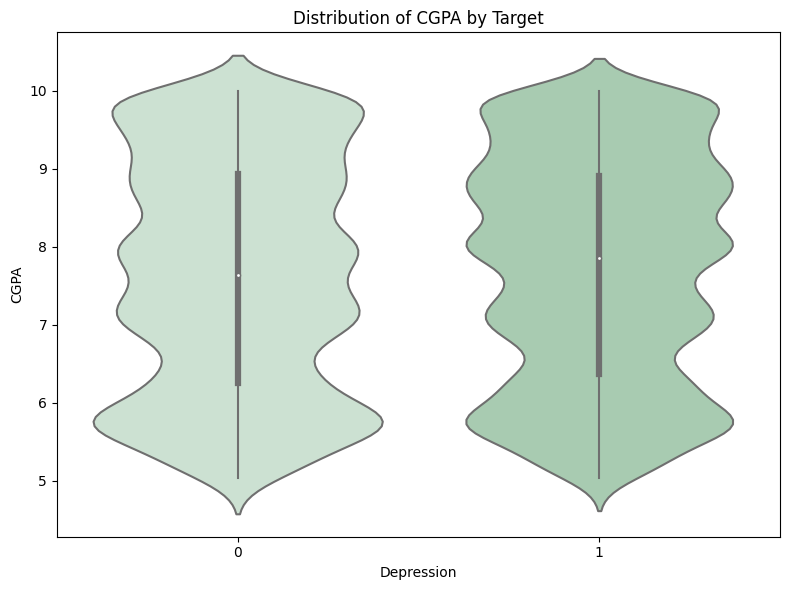

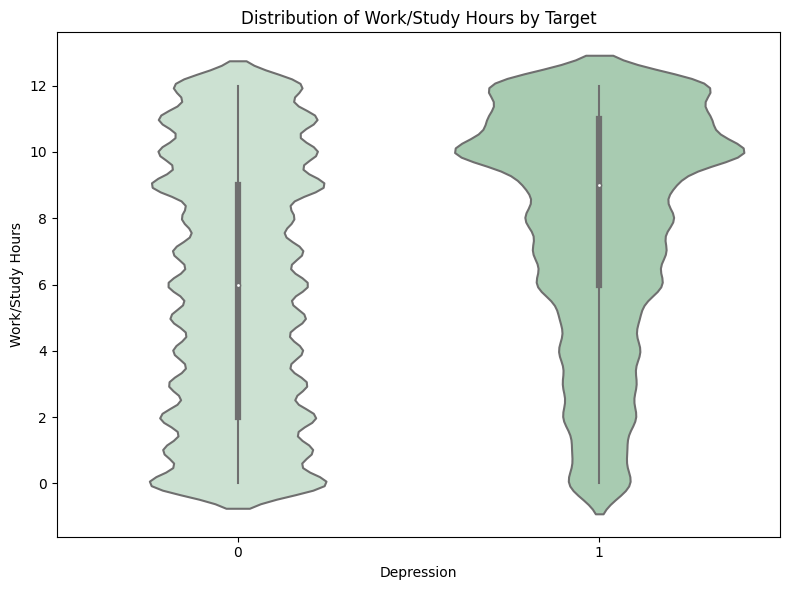

In [11]:
bi_palette = [colors[3], colors[0]]

for column in numerical_columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df_train, x=target_column, y=column) 
    plt.title(f'Distribution of {column} by Target')

    plt.tight_layout()
    plt.show()

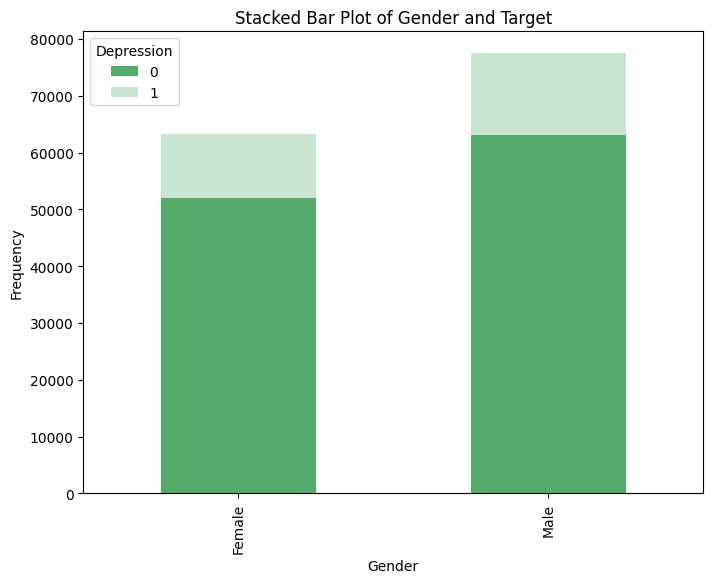

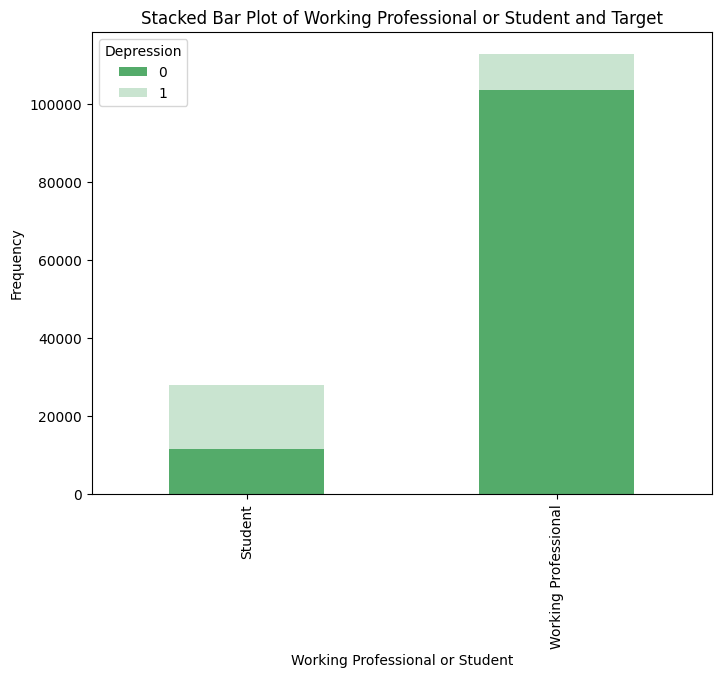

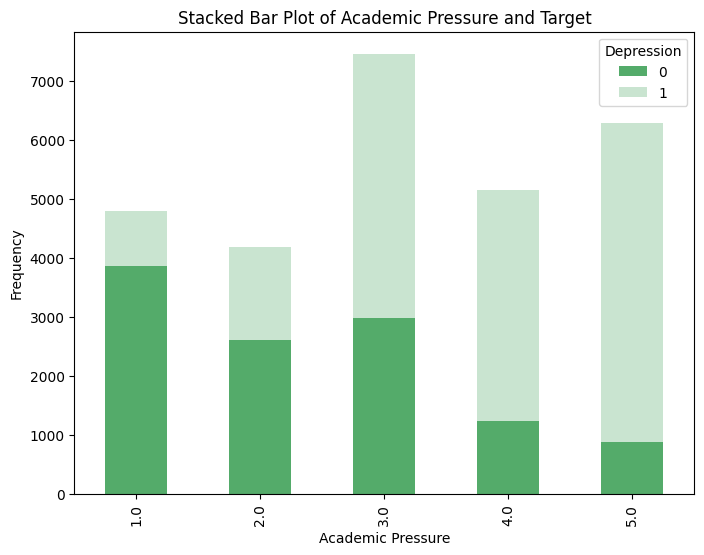

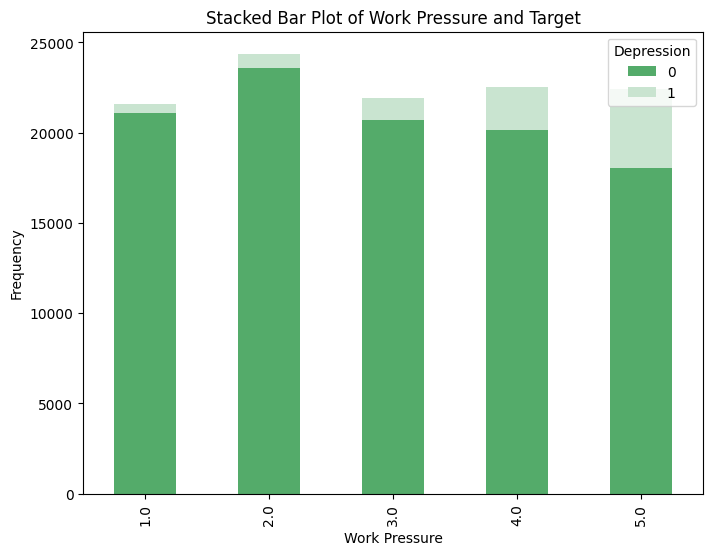

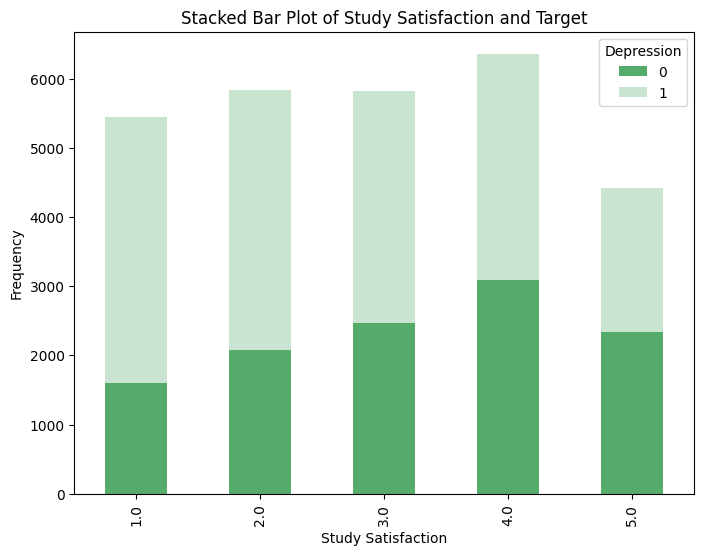

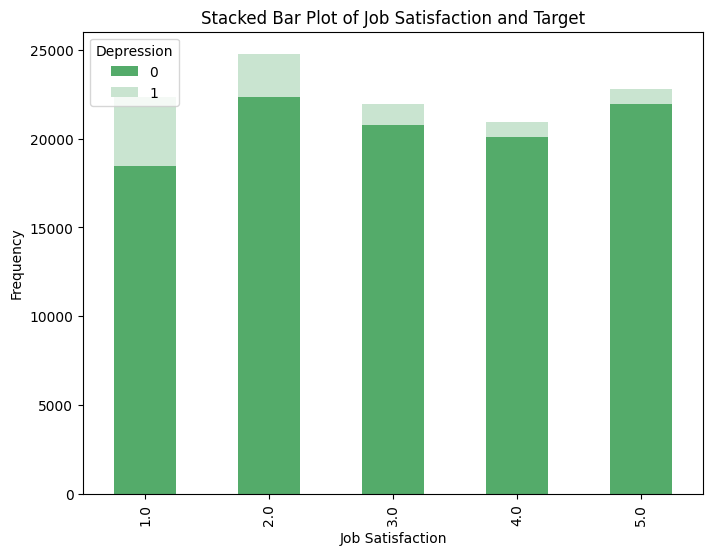

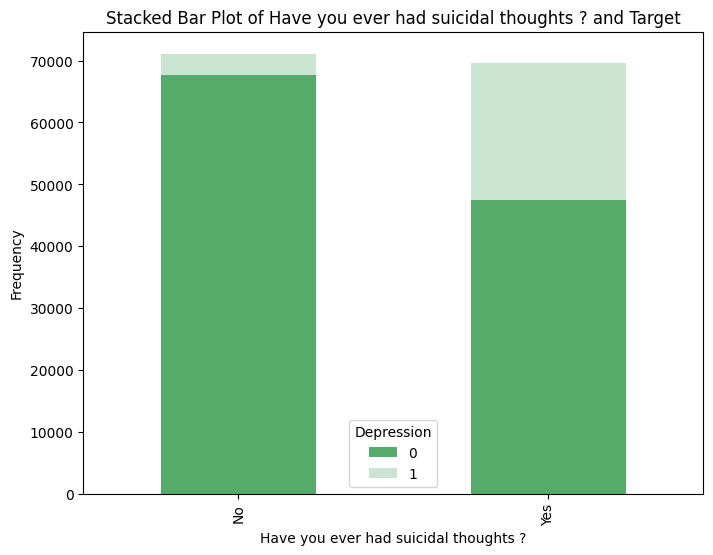

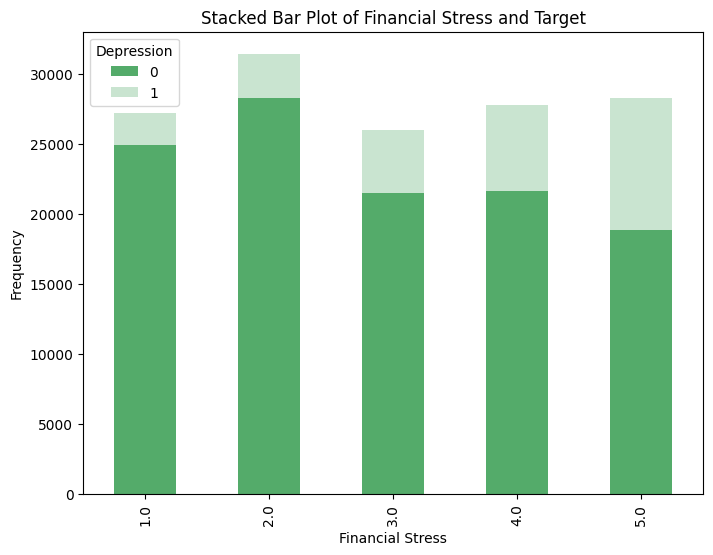

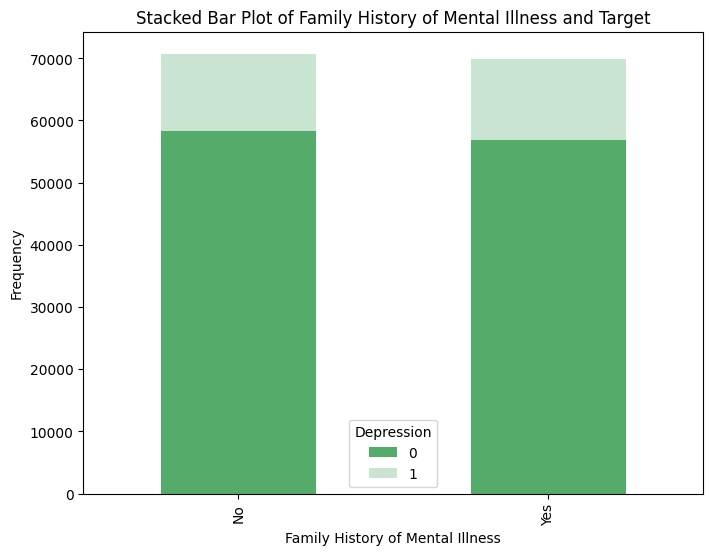

In [12]:
cmap = LinearSegmentedColormap.from_list("custom_cmap", bi_palette)

# Loop through each categorical column in your list
for column in categorical_columns_to_plot: 
    # Stacked Bar Plot
    pd.crosstab(df_train[column], df_train[target_column]).plot(kind='bar', stacked=True, colormap=cmap, figsize=(8, 6))
    plt.title(f"Stacked Bar Plot of {column} and Target")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

### <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:90%; font-family:Arial, sans-serif; background-color:#C84C05; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 3.7. Distribution of a Target Variable </b></div>

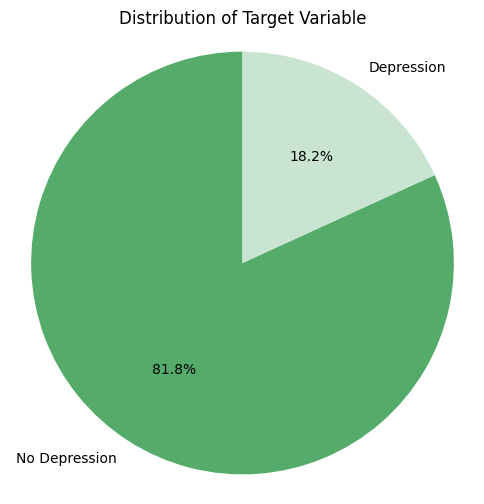

In [13]:
# Calculate counts for the pie chart and add labels
class_counts = df_train[target_column].value_counts().sort_index()
labels = ["No Depression", "Depression"]
plt.figure(figsize=(6, 6))
plt.pie(class_counts, colors=bi_palette, labels=labels,
        autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()